#  Tomato vs Cucumber Image Classifier Using OpenCV (No Machine Learning)

**A separate Jupyter Notebook file has been created specifically for the convenience of users — Tomato or Cucumber Classifier.ipynb — designed for direct launch via GitHub.**

The main differences from GreenOrRed.ipynb:

* Detailed explanations and theoretical comments have been removed

* Added diagnostic information in the output

Upload an image of a tomato or cucumber


Saving tomato.jpeg to tomato.jpeg


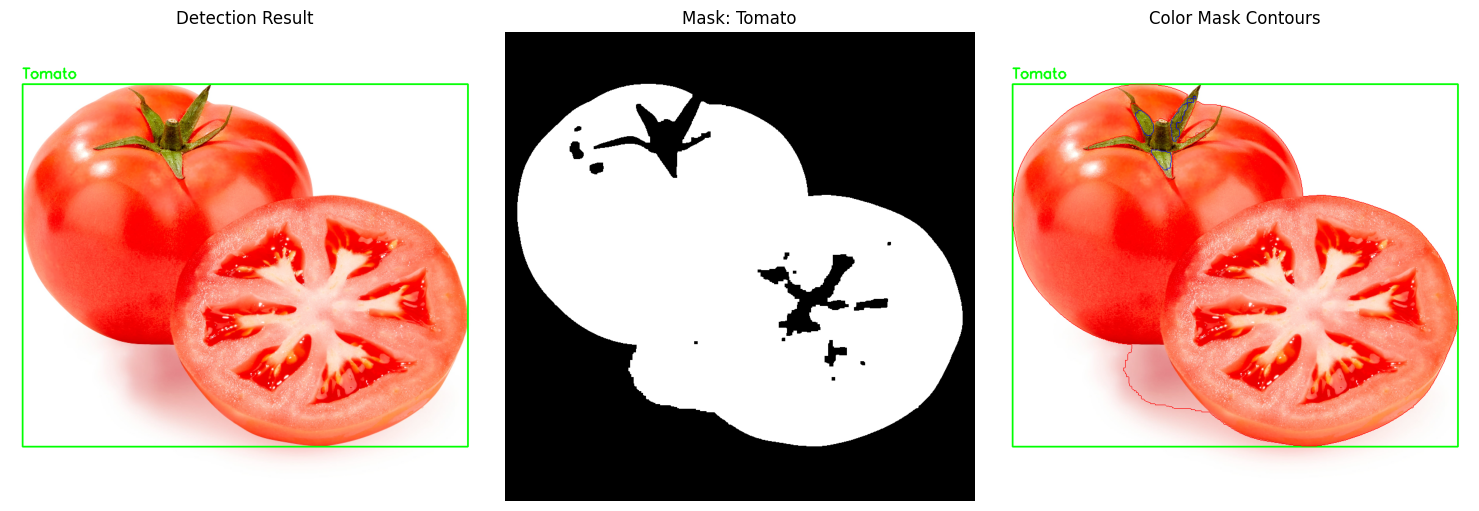

Detected vegetable: Tomato
Color mask area: 295079
Contour area: 303812.5
Roundness: 0.40
Aspect ratio: 1.23
Mean hue (H): 6.0
Mean saturation (S): 175.5
Mean brightness (V): 251.5
tomato.jpeg                    -> Tomato


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

VEGETABLES_HSV = {
    "Tomato": [
        np.array([0, 60, 60]),
        np.array([15, 255, 255]),
        np.array([165, 60, 60]),
        np.array([180, 255, 255])
    ],
    "Cucumber": [
        np.array([25, 40, 40]),
        np.array([90, 255, 255])
    ]
}

MIN_AREA = 1000
KERNEL = np.ones((5, 5), np.uint8)

def detect_vegetable(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    h, w = img.shape[:2]
    if w > 800:
        new_w = 800
        new_h = int(h * (800 / w))
        img = cv2.resize(img, (new_w, new_h))
    else:
        img = cv2.resize(img, (600, 400))

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    masks = {}
    areas = {}

    for vegetable, bounds in VEGETABLES_HSV.items():
        if vegetable == "Tomato":
            mask1 = cv2.inRange(hsv, bounds[0], bounds[1])
            mask2 = cv2.inRange(hsv, bounds[2], bounds[3])
            mask = cv2.bitwise_or(mask1, mask2)
        else:
            mask = cv2.inRange(hsv, bounds[0], bounds[1])

        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERNEL)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, KERNEL)
        masks[vegetable] = mask
        areas[vegetable] = cv2.countNonZero(mask)

    detected = None
    max_area = 0
    for veg, area in areas.items():
        if area > max_area and area >= MIN_AREA:
            max_area = area
            detected = veg

    if detected is None:
        return None

    final_mask = masks[detected]
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    contour_area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    circularity = 4 * np.pi * contour_area / (perimeter * perimeter + 1e-8)
    aspect_ratio = float(w) / h if h > 0 else 0

    hsv_pixels_in_mask = hsv[final_mask > 0]
    if len(hsv_pixels_in_mask) == 0:
        return None

    mean_hue = np.mean(hsv_pixels_in_mask[:, 0])
    mean_saturation = np.mean(hsv_pixels_in_mask[:, 1])
    mean_value = np.mean(hsv_pixels_in_mask[:, 2])

    is_tomato_valid = False
    is_cucumber_valid = False

    if detected == "Tomato":
        if circularity >= 0.4 and mean_saturation >= 50:
            is_tomato_valid = True
    elif detected == "Cucumber":
        if aspect_ratio >= 1.2 and circularity <= 0.8:
            is_cucumber_valid = True

    if (detected == "Tomato" and not is_tomato_valid) or (detected == "Cucumber" and not is_cucumber_valid):
        if max_area < 20000:
            return None

    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img, detected, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Detection Result")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(final_mask, cmap='gray')
    plt.title(f"Mask: {detected}")
    plt.axis("off")

    combined_img = img.copy()
    color_map = {"Tomato": (0, 0, 255), "Cucumber": (255, 0, 0)}
    for veg, mask in masks.items():
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in cnts:
            if cv2.contourArea(contour) > MIN_AREA // 2:
                cv2.drawContours(combined_img, [contour], -1, color_map[veg], 1)

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
    plt.title("Color Mask Contours")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Detected vegetable: {detected}")
    print(f"Color mask area: {max_area}")
    print(f"Contour area: {contour_area}")
    print(f"Roundness: {circularity:.2f}")
    print(f"Aspect ratio: {aspect_ratio:.2f}")
    print(f"Mean hue (H): {mean_hue:.1f}")
    print(f"Mean saturation (S): {mean_saturation:.1f}")
    print(f"Mean brightness (V): {mean_value:.1f}")

    return detected

print("Upload an image of a tomato or cucumber")
uploaded = files.upload()

if not uploaded:
    print("No files were uploaded.")
else:
    results = []
    for filename in uploaded.keys():
        result = detect_vegetable(filename)
        results.append((filename, result if result else "Not Detected"))

    print("=" * 60)
    for fname, veg in results:
        print(f"{fname:<30} -> {veg}")
    print("=" * 60)